In [399]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn

In [400]:
seed = 42
np.random.seed(seed)

In [401]:
train_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_train.csv"
test_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_test.csv"

train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

In [402]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               14105 non-null  object 
 1   price              14105 non-null  float64
 2   bedrooms           14105 non-null  int64  
 3   grade              14105 non-null  int64  
 4   has_basement       14105 non-null  bool   
 5   living_in_m2       14105 non-null  float64
 6   renovated          14105 non-null  bool   
 7   nice_view          14105 non-null  bool   
 8   perfect_condition  14105 non-null  bool   
 9   real_bathrooms     14105 non-null  int64  
 10  has_lavatory       14105 non-null  bool   
 11  single_floor       14105 non-null  bool   
 12  month              14105 non-null  int64  
 13  quartile_zone      14105 non-null  int64  
dtypes: bool(6), float64(2), int64(5), object(1)
memory usage: 964.3+ KB


# EDA - Exploratory Data Analysis 

In [403]:
train_data.drop("date", axis=1, inplace=True)
test_data.drop("date", axis=1, inplace=True)

In [404]:
# Liste over boolske kolonner
bool_columns = ["has_basement", "renovated", "nice_view", "perfect_condition", "has_lavatory", "single_floor"]

# Endrer dem til int verdier 0/1
train_data[bool_columns] = train_data[bool_columns].astype(int)
test_data[bool_columns] = test_data[bool_columns].astype(int)

In [405]:
#Sjekk manglende verdier
manglende_verdier = train_data.isnull().sum()
print("Manglende verdier", manglende_verdier)

Manglende verdier price                0
bedrooms             0
grade                0
has_basement         0
living_in_m2         0
renovated            0
nice_view            0
perfect_condition    0
real_bathrooms       0
has_lavatory         0
single_floor         0
month                0
quartile_zone        0
dtype: int64


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'has_basement'}>],
       [<Axes: title={'center': 'living_in_m2'}>,
        <Axes: title={'center': 'renovated'}>,
        <Axes: title={'center': 'nice_view'}>,
        <Axes: title={'center': 'perfect_condition'}>],
       [<Axes: title={'center': 'real_bathrooms'}>,
        <Axes: title={'center': 'has_lavatory'}>,
        <Axes: title={'center': 'single_floor'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'quartile_zone'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

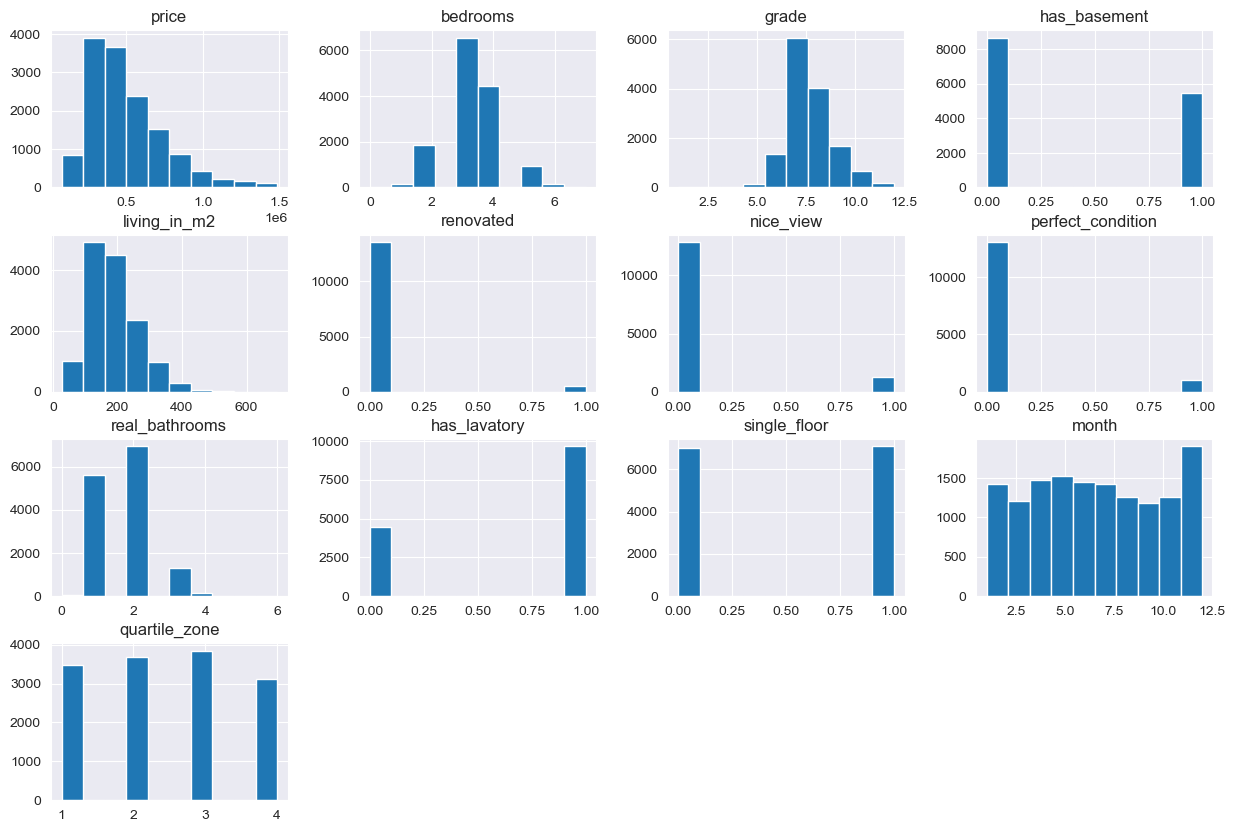

In [406]:
train_data.hist(figsize=(15, 10))

<Axes: >

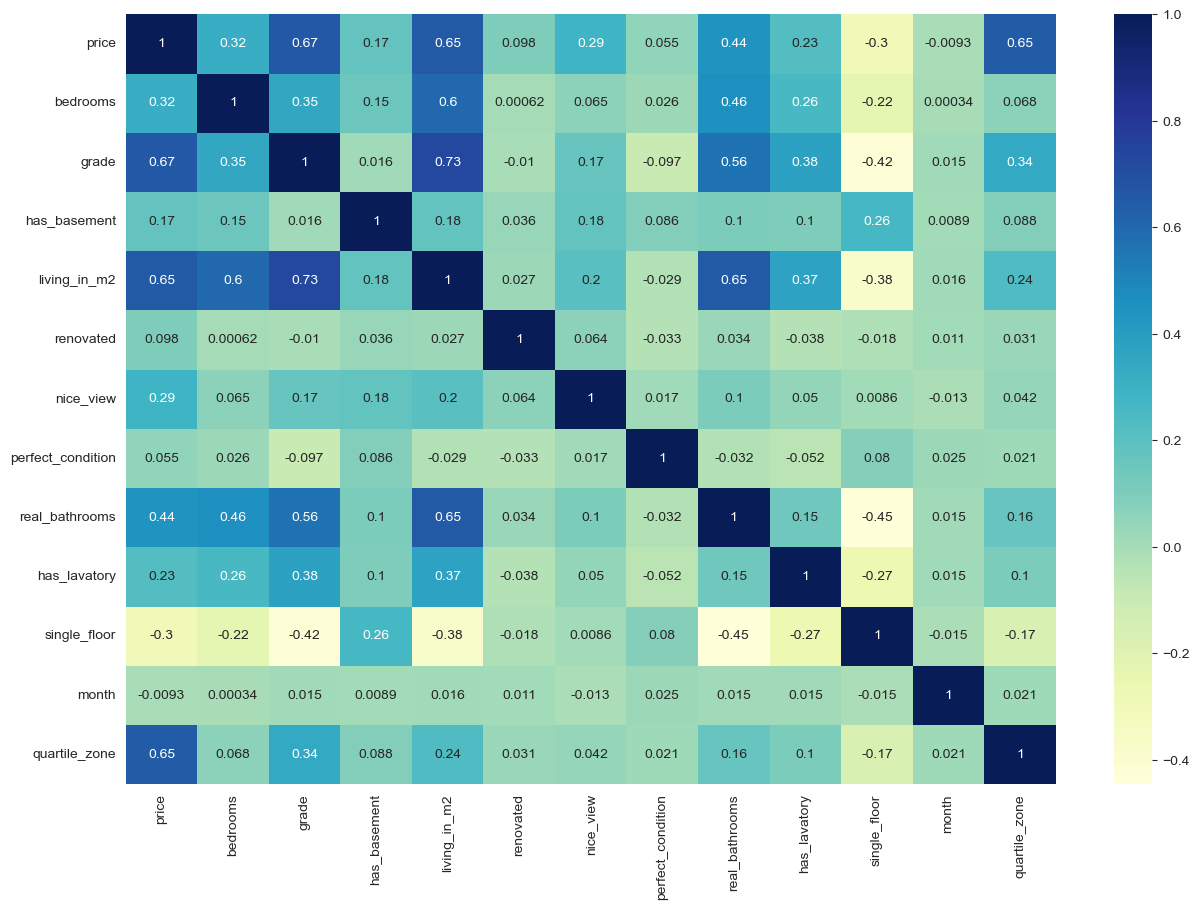

In [407]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap = "YlGnBu")

In [408]:
#Log-transformerer data som er skevt fordelt

train_data['price'] = np.log1p(train_data['price'])
train_data['living_in_m2'] = np.log1p(train_data['living_in_m2'])
train_data['real_bathrooms'] = np.log1p(train_data['real_bathrooms'])

**Vi kan se en mye bedre fordeling nå!**

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'has_basement'}>],
       [<Axes: title={'center': 'living_in_m2'}>,
        <Axes: title={'center': 'renovated'}>,
        <Axes: title={'center': 'nice_view'}>,
        <Axes: title={'center': 'perfect_condition'}>],
       [<Axes: title={'center': 'real_bathrooms'}>,
        <Axes: title={'center': 'has_lavatory'}>,
        <Axes: title={'center': 'single_floor'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'quartile_zone'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

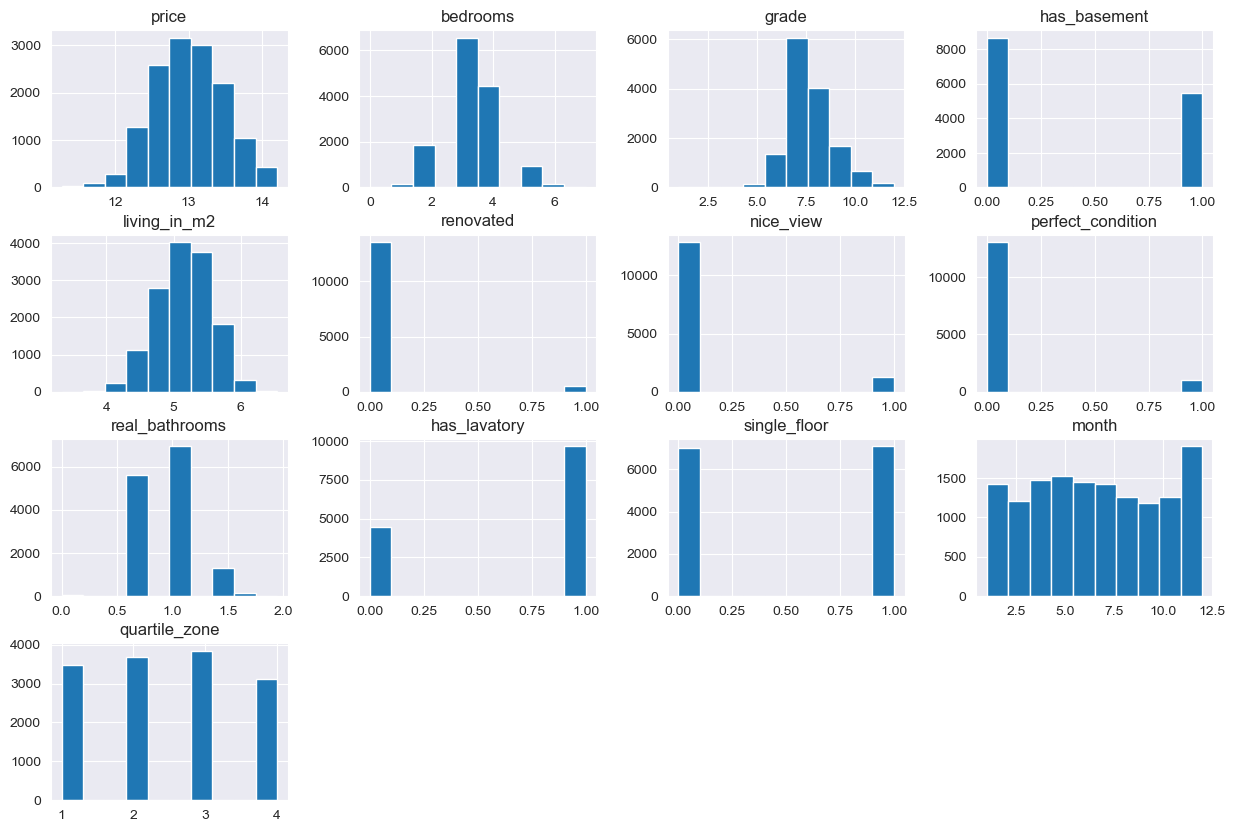

In [409]:
train_data.hist(figsize=(15, 10))

In [410]:
#transformerer month om til sykliske variabler for å gjennkjenne sesongbaserte aktiviteter
data = pd.DataFrame({
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
})

train_data['month_sin'] = np.sin(2*np.pi*train_data['month']/12)
train_data['month_cos'] = np.cos(2*np.pi*train_data['month']/12)

train_data.drop('month', axis=1, inplace=True)

# Feature Engineering

In [411]:
# Pris per kvadratmeter:
train_data['price_per_m2'] = train_data['price']/train_data['living_in_m2']

# Bad per soverom:
#['bathroom_to_bedroom_ratio'] = train_data['real_bathrooms']/train_data['bedrooms'] - Denne ga null-verdier

#pris relativ til område:
train_data['price_to_quantile_ratio'] = train_data['price']/train_data['quartile_zone']

<Axes: >

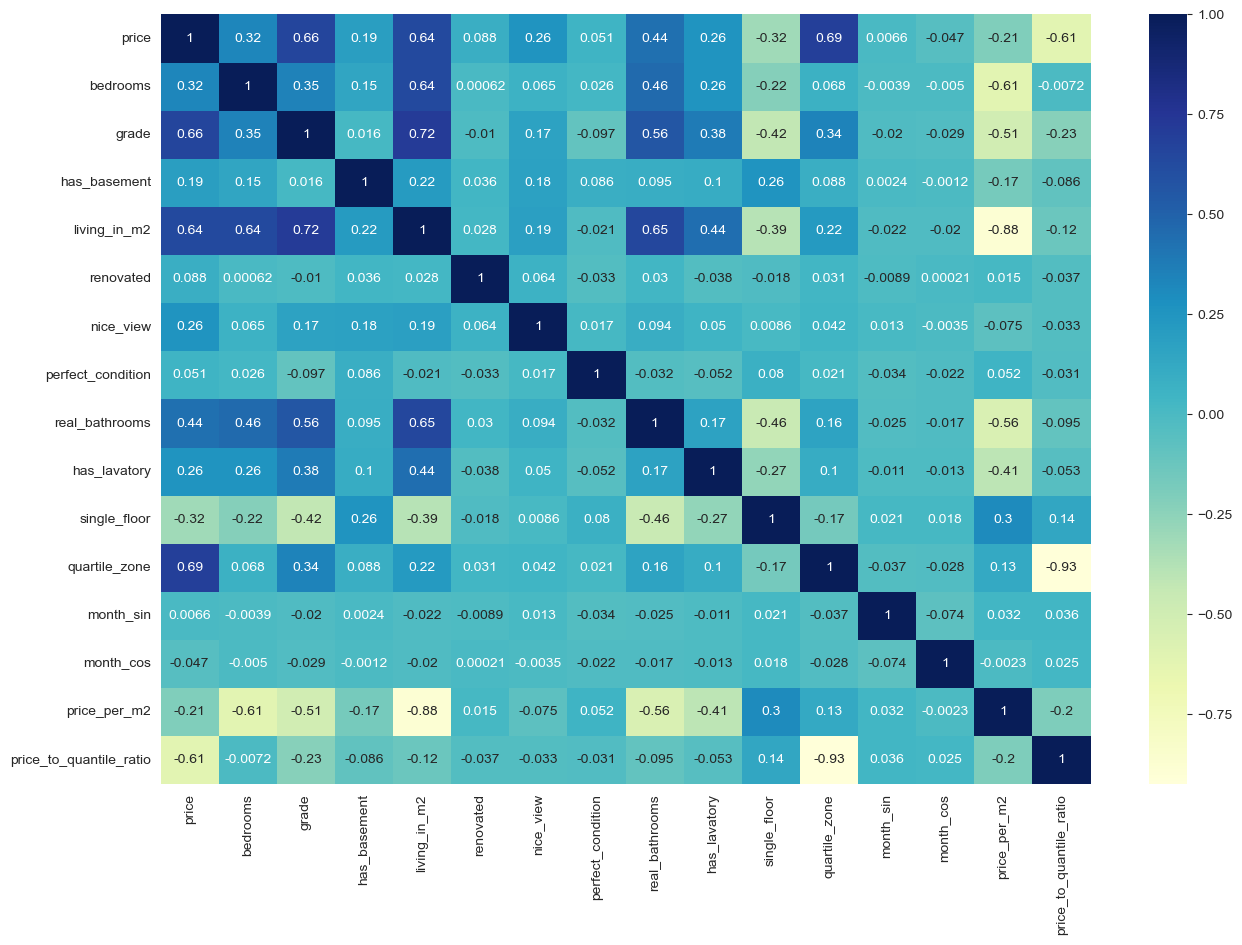

In [412]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap = "YlGnBu")

# Splitting og bestemmelse av modell 

In [413]:
from sklearn.model_selection import train_test_split
X = train_data.drop('price', axis=1)
y = train_data['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [414]:
#pip install xgboost

In [415]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=seed, n_jobs=-1)

from xgboost import XGBRegressor
model_XGBR = XGBRegressor(random_state=seed, n_jobs=-1)

from sklearn.ensemble import GradientBoostingRegressor
model_GBR = GradientBoostingRegressor()

In [416]:
rf_reg.fit(X_train, y_train)
model_XGBR.fit(X_train, y_train)
model_GBR.fit(X_train, y_train)

GradientBoostingRegressor()

In [417]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

XGBR_predictions = model_XGBR.predict(X_val)
GBR_predictions = model_GBR.predict(X_val)
RF_predictions = rf_reg.predict(X_val)

XGBR_mae = mean_absolute_error(y_val, XGBR_predictions)
XGBR_rmse = np.sqrt(mean_squared_error(y_val, XGBR_predictions))

GBR_mae = mean_absolute_error(y_val, GBR_predictions)
GBR_rmse = np.sqrt(mean_squared_error(y_val, GBR_predictions))

RF_mae = mean_absolute_error(y_val, RF_predictions)
RF_rmse = np.sqrt(mean_squared_error(y_val, RF_predictions))

print ("RandomForestR. - MAE: ", RF_mae, "RMSE: ", RF_rmse)
print ("Gradient Boosting. - MAE: ", GBR_mae, "RMSE: ", GBR_rmse)
print("XGBoost - MAE: ", XGBR_mae, "RMSE: ", XGBR_rmse)

RandomForestR. - MAE:  0.0020641042737605687 RMSE:  0.00929514619132086
Gradient Boosting. - MAE:  0.05366840488427799 RMSE:  0.07554712839684834
XGBoost - MAE:  0.014806894213123274 RMSE:  0.02932846048559742


**Som vi Ser presterer Random Forest-modellen best!**

MAE(Mean Absolute Error) og RMSE(Root Mean Sqaured Error) er to vanlig metrikker for å evaluere regresjonsmodeller.
- **MAE**: Gjennomsnittet av de absolutte feilene mellom prediksjoner og faktiske verdier. Den måler hvor mye modellen bommer i gjennomsnitt.
- **RMSE**: Kvadratroten av gjennomsnittet av de kvadrerte feilene. Derfor straffes større feil hardere enn MAE, altså avvikene. Dette fordi          feilene kvadreres.

**MAE** gir direkte måling av gjennomsnittlig feil, mens **RMSE** straffer store feil mer og gir indikator på store avvik.


In [418]:
#from sklearn.model_selection import GridSearchCV
#rf_model = RandomForestRegressor(random_state=seed, n_jobs=-1)

#param_grid = {
#   "n_estimators": [100, 200, 300, 500],  # Økt antall trær
#   "max_features": ["sqrt", "log2", 2, 4, 6, 8],  # Inkluderer både numeriske og standard verdier
#    "max_depth": [3, 5, 7, 10],  # Legger til max_depth for å kontrollere treets dybde
#    "min_samples_split": [8, 10, 12],  # Minimum antall prøver for splitting
#    "min_samples_leaf": [3, 4, 5]  # Minimum antall prøver per bladnode
#}

#grid_search = GridSearchCV(rf_reg, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)

#print("beste parametre: ", grid_search.best_params_)
#print("beste score: ", grid_search.best_score_)

beste parametre:  {'max_depth': None, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
beste score:  -0.0007095774655469137

In [419]:
best_model = RandomForestRegressor(
    random_state=seed, 
    n_jobs=-1,
    max_features= 20,
    n_estimators=500,
    max_depth=None,
    min_samples_split=8,
    min_samples_leaf=3,
    bootstrap=True,
)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_features=20, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [420]:
# Treningsscore
train_predictions = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = best_model.score(X_train, y_train)

# Valideringsscore
val_predictions = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = best_model.score(X_val, y_val)

print("Treningsscore:")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)

print("\nValideringsscore:")
print("MSE:", val_mse)
print("MAE:", val_mae)
print("R2:", val_r2)

Treningsscore:
MSE: 0.00011818988898098521
MAE: 0.001743446863331805
R2: 0.999480475392714

Valideringsscore:
MSE: 0.0001728973629481243
MAE: 0.002381815621582383
R2: 0.9992229375394726


***Det vi kan se at modellen generealiserer godt siden det er liten forksjell mellom trening-score og validering-score!***

# Reflekter endringer over på det urørte test_data settet

In [421]:
# Log-transformasjonene
test_data['price'] = np.log1p(test_data['price'])
test_data['living_in_m2'] = np.log1p(test_data['living_in_m2'])
test_data['real_bathrooms'] = np.log1p(test_data['real_bathrooms'])

# Syklisk transformasjon for `month`
test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / 12)

# Fjern `month` etter syklisk transformasjon
test_data.drop('month', axis=1, inplace=True)

# Ny funksjon: pris per kvadratmeter
test_data['price_per_m2'] = test_data['price'] / test_data['living_in_m2']

# Ny funksjon: pris relativ til kvartilsone
test_data['price_to_quantile_ratio'] = test_data['price'] / test_data['quartile_zone']

**Undersøker om de fortsatt er like, og det er de!**

In [422]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    14105 non-null  float64
 1   bedrooms                 14105 non-null  int64  
 2   grade                    14105 non-null  int64  
 3   has_basement             14105 non-null  int32  
 4   living_in_m2             14105 non-null  float64
 5   renovated                14105 non-null  int32  
 6   nice_view                14105 non-null  int32  
 7   perfect_condition        14105 non-null  int32  
 8   real_bathrooms           14105 non-null  float64
 9   has_lavatory             14105 non-null  int32  
 10  single_floor             14105 non-null  int32  
 11  quartile_zone            14105 non-null  int64  
 12  month_sin                14105 non-null  float64
 13  month_cos                14105 non-null  float64
 14  price_per_m2          

In [423]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6948 entries, 0 to 6947
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    6948 non-null   float64
 1   bedrooms                 6948 non-null   int64  
 2   grade                    6948 non-null   int64  
 3   has_basement             6948 non-null   int32  
 4   living_in_m2             6948 non-null   float64
 5   renovated                6948 non-null   int32  
 6   nice_view                6948 non-null   int32  
 7   perfect_condition        6948 non-null   int32  
 8   real_bathrooms           6948 non-null   float64
 9   has_lavatory             6948 non-null   int32  
 10  single_floor             6948 non-null   int32  
 11  quartile_zone            6948 non-null   int64  
 12  month_sin                6948 non-null   float64
 13  month_cos                6948 non-null   float64
 14  price_per_m2            

In [425]:
# Fjern målvariabelen `price` fra test_data når du lager prediksjoner
X_test = test_data.drop('price', axis=1)
y_test = test_data['price']  # Dette er de faktiske verdiene vi sammenligner med

# Lag prediksjoner
test_predictions = best_model.predict(X_test)

# Sammenlign prediksjonene med de faktiske `price`-verdiene i testsettet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R²:", test_r2)

Test MSE: 0.00014730031012953577
Test MAE: 0.002413254292411245
Test R²: 0.9993453109607497


In [426]:
 # Lagre modellen
 #joblib.dump(best_model, "final_model.joblib")

['final_model.joblib']